# Tae-Seung Kim Module 6

In [365]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as metrics
import os
import sys
from sklearn.model_selection import KFold
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, f1_score, average_precision_score, roc_curve, precision_recall_fscore_support, precision_recall_curve, confusion_matrix, classification_report

In [366]:
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [454]:
module_path

'c:\\Users\\tkkim\\Desktop\\nw_msds\\451_financial_machine_learning\\week_6\\src'

In [457]:
import src.sharpe_ratio_stats as sr_funcs

In [134]:
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = 12, 7

In [232]:
def getWeights_FFD(d,thres):
    w,k=[1.],1
    while True:
        w_=-w[-1]/k*(d-k+1)
        if abs(w_)<thres:break
        w.append(w_);k+=1
    return np.array(w[::-1]).reshape(-1,1)

def fracDiff_FFD(series,d,thres=1e-5):
    # Constant width window (new solution)
    w=getWeights_FFD(d,thres)
    df={}
    for name in series.columns:
        df_= pd.Series(series[name].values,index=series.index).fillna(method='ffill').dropna()
        x = pd.Series(0,index=df_.index)
        for k in range(w.shape[0]):
            x = x+w[k,0]*df_.shift(-k)
    #df[name]=x.dropna().copy(deep=True)
    df[name]=x.shift(k).copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def findMinD(series):
    for d in np.linspace(0,1,11):
        df_=fracDiff_FFD(series,d,thres=0.01).dropna()
        res=adfuller(df_.iloc[:,0].values,maxlag=1,regression='c',autolag=None)
        if (res[0]<=res[4]['5%']):
            return d
    return 1.0

In [388]:
class rfmodel:
    # on creation
    def __init__(self, name, data, seed=1, split=True, model=RandomForestClassifier(n_estimators=100,random_state=1)):
        self.name = name
        self.data = data.copy()
        self.seed = seed
        self.model = model
        self.split = split

    def splitdata(self, test_size=0.2):
        if self.split == True:
            self.xdata = self.data.copy().drop(['target'], axis=1)
            #dividends included is the target
            self.ydata = self.data['target'].copy()
            #any target giving > 0 returns is a good enough trade
            self.X_Train, self.X_Test, self.Y_Train, self.Y_Test = train_test_split(self.xdata, self.ydata, test_size=test_size, random_state=1,shuffle=False)
        else:
            self.xdata = self.data.copy().drop(['target'], axis=1)
            self.ydata = self.data['target'].copy()

    def alt_splitdata(self, test_size=0.2):
        self.xdata = self.data.copy().drop(['ret'], axis=1)
        self.xdata.set_index('yyyymm', inplace=True)
        self.ydata = self.data.copy()[['yyyymm','ret']]
        self.ydata.set_index('yyyymm', inplace=True)
        self.X_Train, self.X_Test, self.Y_Train, self.Y_Test = train_test_split(self.xdata, self.ydata, test_size=test_size, random_state=1,shuffle=False)

    def featImpMDA_classify(self,cv=10):
        X = self.xdata
        y = self.ydata
        np.random.seed(self.seed)
        # feat importance based on OOS score reduction
        print('start MDA',dt.datetime.now())
        from sklearn.metrics import log_loss
        cvGen=KFold(n_splits=cv)
        scr0,scr1=pd.Series(dtype='float64'),pd.DataFrame(columns=X.columns)
        for i,(train,test) in enumerate(cvGen.split(X=X)):
            print('   Split',i+1)
            X0, y0=X.iloc[train,:],y.iloc[train]
            X1, y1=X.iloc[test,:],y.iloc[test]  
            fit=self.model.fit(X=X0,y=y0.values.ravel())
            pred=fit.predict_proba(X1)
            #neg log loss from snippet 8.3
            scr0.loc[i]=-log_loss(y1,pred[:,1], sample_weight=None, labels=self.model.classes_)
            for j in X.columns:
                X1_=X1.copy(deep=True)
                np.random.shuffle(X1_[j].values) # permutation of a single column
                pred=fit.predict_proba(X1_)
            
                scr1.loc[i,j]=-log_loss(y1,pred[:,1], sample_weight=None, labels=self.model.classes_)
        #neg log loss from snippet 8.3
        imp=(-scr1).add(scr0,axis=0)
        imp=imp/-scr1
        imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
        print('end MDA',dt.datetime.now())
        self.imp_raw = imp
        self.imp = self.imp_raw.reset_index().rename(index=int,
                                                columns={"index":"Feature",'mean':'Importance'}, 
                                                inplace=False).set_index('Feature')
        self.imp = self.imp.sort_values(by='Importance')
        self.scr0 = scr0
        self.scr1 = scr1

    def fit(self):
        self.model.fit(self.X_Train, self.Y_Train)

    def pred(self):
        if self.split == True:
            self.Y_Pred_Train = self.model.predict(self.X_Train)
            self.Y_Pred_Test = self.model.predict(self.X_Test)
            self.train_probs = self.model.predict_proba(self.X_Train)
            self.test_probs = self.model.predict_proba(self.X_Test)
            self.train_probs = self.train_probs[:,1]
            self.test_probs = self.test_probs[:,1]
        else:
            self.preds = self.model.predict(self.xdata)
            self.probs = self.model.predict_proba(self.xdata)
            self.probs = self.probs[:,1]
        

    def getAccuracy(self):
        if self.split == True:
            self.precision_train, self.precision_train, self.train_threshold = metrics.precision_recall_curve(self.Y_Train, self.train_probs)
            self.precision_test, self.precision_test, self.test_threshold = metrics.precision_recall_curve(self.Y_Test, self.test_probs)
            self.auc_train = average_precision_score(self.Y_Train, self.Y_Pred_Train)
            self.auc_test = average_precision_score(self.Y_Test, self.Y_Pred_Test)
            self.train_acc = metrics.accuracy_score(self.Y_Train, self.Y_Pred_Train)
            self.test_acc = metrics.accuracy_score(self.Y_Test, self.Y_Pred_Test)
            self.f1_train = f1_score(self.Y_Train, self.Y_Pred_Train)
            self.f1_test = f1_score(self.Y_Test, self.Y_Pred_Test)
            self.bigscoretest = precision_recall_fscore_support(self.Y_Test, self.Y_Pred_Test, average='binary')
            self.bigscoretrain = precision_recall_fscore_support(self.Y_Train, self.Y_Pred_Train, average='binary')
        else:
            self.precision, self.recall, self.threshold = metrics.precision_recall_curve(self.ydata, self.probs)
            self.auc = average_precision_score(self.ydata, self.preds)
            self.acc = metrics.accuracy_score(self.ydata, self.preds)
            self.f1 = f1_score(self.ydata, self.preds)
            self.bigscore = precision_recall_fscore_support(self.ydata, self.preds, average='binary')

    def makePRplot(self):
        if self.split == True:
            self.plot1 = PrecisionRecallDisplay.from_predictions(self.Y_Test, self.Y_Pred_Test, drawstyle="default")
            self.plot1.ax_.set_title(self.name + " Test Precision Recall Curve")
            self.plot2 = PrecisionRecallDisplay.from_predictions(self.Y_Train, self.Y_Pred_Train, drawstyle="default")
            self.plot2.ax_.set_title(self.name + " Train Precision Recall Curve")
            #plt.show()
        else:
            self.plot = PrecisionRecallDisplay.from_predictions(self.ydata, self.probs, drawstyle="default")
            self.plot.ax_.set_title(self.name + " Precision Recall Curve")
            #plt.show()
    
    def makeROCplot(self):
        if self.split == True:
            self.plot1 = RocCurveDisplay.from_predictions(self.Y_Test, self.Y_Pred_Test, drawstyle="default")
            self.plot1.ax_.set_title(self.name + " Test Precision Recall Curve")
            self.plot2 = RocCurveDisplay.from_predictions(self.Y_Train, self.Y_Pred_Train, drawstyle="default")
            self.plot2.ax_.set_title(self.name + " Train Precision Recall Curve")
        else:
            self.plot = RocCurveDisplay.from_predictions(self.ydata, self.probs, drawstyle="default")
            self.plot.ax_.set_title(self.name + " Precision Recall Curve")
            
        
    def plot_importances(self, save=None, xrot=0, tickstep=3,
                     label_fontsize=12,
                     figsize=None, scalefig=(1.0, 1.0), show=True):
        """
        Given an array or data frame of importances, plot a horizontal bar chart
        showing the importance values.

        :param df_importances: A data frame with Feature, Importance columns
        :type df_importances: pd.DataFrame
        :param save: A filename identifying where to save the image.
        :param xrot: Degrees to rotate importance (X axis) labels
        :type xrot: int
        :param tickstep: How many ticks to skip in X axis
        :type tickstep: int
        :param label_fontsize:  The font size for the column names and x ticks
        :type label_fontsize:  int
        :param figsize: Specify width and height of image (width,height)
        :type figsize: 2-tuple of floats
        :param scalefig: Scale width and height of image (widthscale,heightscale)
        :type scalefig: 2-tuple of floats
        :param show: Execute plt.show() if true (default is True). Sometimes
                    we want to draw multiple things before calling plt.show()
        :type show: bool
        :return: None

        SAMPLE CODE

        rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
        X_train, y_train = ..., ...
        rf.fit(X_train, y_train)
        imp = importances(rf, X_test, y_test)
        plot_importances(imp)
        """
        df_importances = self.imp

        I = df_importances

        if figsize:
            fig = plt.figure(figsize=figsize)
        elif scalefig:
            fig = plt.figure()
            w, h = fig.get_size_inches()
            fig.set_size_inches(w * scalefig[0], h * scalefig[1], forward=True)
        else:
            fig = plt.figure()
        ax = plt.gca()
        labels = []
        for col in I.index:
            if isinstance(col, list):
                labels.append('\n'.join(col))
            else:
                labels.append(col)

        for tick in ax.get_xticklabels():
            tick.set_size(label_fontsize)
        for tick in ax.get_yticklabels():
            tick.set_size(label_fontsize)
        ax.barh(np.arange(len(I.index)), I.Importance, height=0.6, tick_label=labels)

        # rotate x-ticks
        if xrot is not None:
            plt.xticks(rotation=xrot)

        # xticks freq
        xticks = ax.get_xticks()
        nticks = len(xticks)
        new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
        ax.set_xticks(new_ticks)

        if save:
            plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
        if show:
            plt.show()



In [136]:
df = pd.read_csv('SPY1.csv')

In [137]:
df.columns = df.columns.str.replace(' ', '') 
df.columns = df.columns.str.lower()


In [138]:
df.isnull().sum()   

date        0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
dtype: int64

In [139]:
df.head()

,date,open,high,low,close,adjclose,volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,24.941402,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.118784,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.172003,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.438091,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,25.544525,531500


In [140]:
df.tail()

,date,open,high,low,close,adjclose,volume
7722,2023-09-29,431.670013,431.850006,425.910004,427.480011,427.480011,115078500
7723,2023-10-02,426.619995,428.600006,424.459991,427.309998,427.309998,83798600
7724,2023-10-03,425.059998,427.369995,420.179993,421.589996,421.589996,103760600
7725,2023-10-04,422.070007,425.429993,420.559998,424.660004,424.660004,87453000
7726,2023-10-05,424.359985,425.369995,421.170013,424.500000,424.500000,70103300


## Question 1

Download SPY data Download SPY data and the Probabilistic Sharpe Ratio. Backtest a naive trading strategy that buys SPY at a month’s end if RF predicts the SPX return will be positive next, and vice versa for shorts. (8 points)

From backtesting (applied our predictive model)

In [258]:
df['date'] = pd.to_datetime(df['date'])

In [299]:
endofmonth = []
dateholder = []
current_month = 1
for i in df.index:
    if df['date'][i].month != current_month:
        current_month = df['date'][i].month
        endofmonth.append(df['date'][i-1].date())
    elif i == df.index[-1]:
        endofmonth.append(df['date'][i].date())
    else:
        continue
    

In [300]:
endofmonth = pd.DataFrame(endofmonth, columns=['date'])
endofmonth['date'] = pd.to_datetime(endofmonth['date'])
eom_df = df[df['date'].isin(endofmonth['date'])].copy()
eom_df.set_index('date', inplace=True)

#df['log_returns'] = np.log(df['close']/df['close'].shift(1)).dropna()
eom_df['log_returns'] = np.log(eom_df['close']) - np.log(eom_df['close'].shift(1))
eom_df.dropna(inplace=True)
eom_df['target'] = np.where(eom_df['log_returns'] > 0, 1, -1)

In [301]:
eom_df.head()

,open,high,low,close,adjclose,volume,log_returns,target
date,,,,,,,,
1993-02-26,44.43750,44.43750,44.18750,44.40625,25.207478,66200,0.010612,1
1993-03-31,45.34375,45.46875,45.18750,45.18750,25.772120,111600,0.017440,1
1993-04-30,44.12500,44.28125,44.03125,44.03125,25.112652,88500,-0.025921,-1
1993-05-28,45.40625,45.40625,45.00000,45.21875,25.789928,79100,0.026612,1
1993-06-30,45.12500,45.21875,45.00000,45.06250,25.882969,437600,-0.003461,-1


In [302]:
# with 30 years of data we can split it into about 20 years of training and 10 years of testing
training = eom_df[eom_df.index < '2013-02-01'].drop(['log_returns'], axis=1)
testing = eom_df[eom_df.index >= '2013-01-01'].drop(['log_returns'], axis=1)

#training = eom_df[eom_df.index < '2013-02-01']
#testing = eom_df[eom_df.index >= '2013-01-01']

In [316]:
q1_model = rfmodel('q1', training)
q1_model.splitdata(test_size=.3)
q1_model.fit()
q1_model.pred()
q1_model.getAccuracy()

In [317]:
q1_model.featImpMDA_classify()

start MDA 2024-02-10 22:20:55.517990
   Split 1
   Split 2
   Split 3
   Split 4
   Split 5
   Split 6
   Split 7
   Split 8
   Split 9
   Split 10
end MDA 2024-02-10 22:20:57.314799


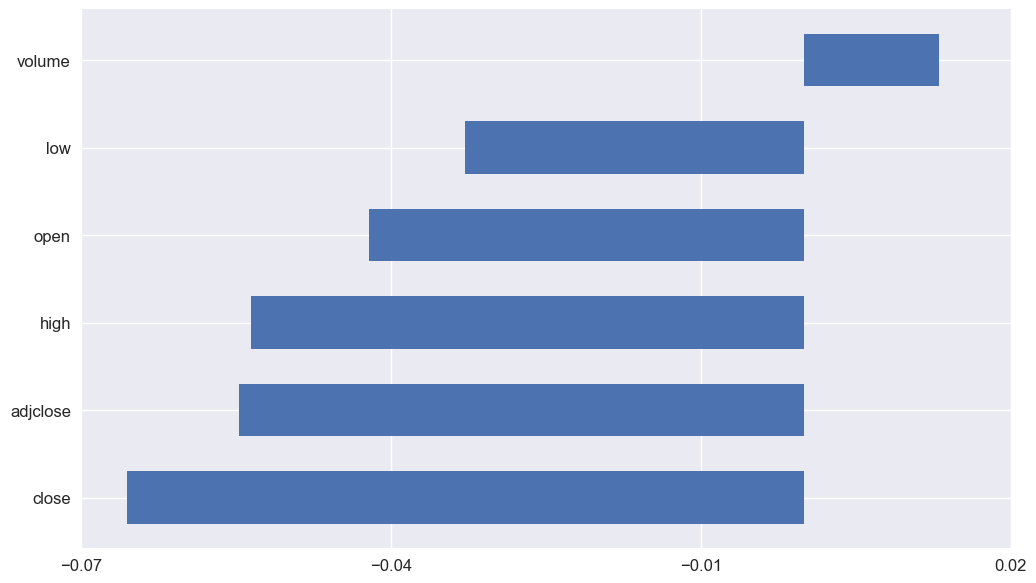

In [318]:
q1_model.plot_importances()

### Q1 Backtest

In [347]:
def annualized_return(returns, periods):
    annualized_return = returns.mean() * 12
    return round(annualized_return, 4)

def annualized_sharpe_ratio(returns, periods):
    sharpe_ratio = returns.mean()/returns.std()
    annualized_sharpe_ratio = sharpe_ratio*np.sqrt(12)
    return round(annualized_sharpe_ratio, 4)

In [349]:
q1backtest.fulldata.groupby(pd.Grouper(freq='YE'))['total_return_exp'].sum()

date
2013-12-31    11.215076
2014-12-31    12.110720
2015-12-31    12.000833
2016-12-31    12.096910
2017-12-31    12.179324
2018-12-31    11.945921
2019-12-31    12.263079
2020-12-31    12.347382
2021-12-31    12.247407
2022-12-31    11.810258
2023-12-31    10.111057
Freq: YE-DEC, Name: total_return_exp, dtype: float64

In [335]:
def backtest(df, model):
    newmodel = rfmodel(model.name+'_backtest', df, split=False, model=model.model)
    for col in newmodel.data.columns:
        if 'log_return' in col:
            newmodel.data.drop(col, axis=1, inplace=True)
    newmodel.splitdata()
    newmodel.pred()
    newmodel.getAccuracy()
    newmodel.fulldata = newmodel.data.copy()
    newmodel.fulldata['predicted'] = newmodel.preds
    newmodel.fulldata['correct'] = np.where(newmodel.fulldata['predicted'] == newmodel.fulldata['target'], 1, 0)
    #newmodel.fulldata.sort_index(inplace=True)
    newmodel.fulldata['log_return'] = np.log(newmodel.fulldata['close']) - np.log(newmodel.fulldata['close'].shift(1))
    newmodel.fulldata['short_return'] = np.where(newmodel.fulldata['predicted'] == -1, -1*newmodel.fulldata['log_return'], 0)
    newmodel.fulldata['long_return'] = np.where(newmodel.fulldata['predicted'] == 1, newmodel.fulldata['log_return'], 0)
    newmodel.fulldata['total_return'] = newmodel.fulldata['short_return'] + newmodel.fulldata['long_return']
    newmodel.fulldata['total_return_exp'] = np.exp(newmodel.fulldata['total_return'])
    newmodel.fulldata['cumulative_return'] = newmodel.fulldata['total_return'].cumsum()
    newmodel.fulldata['cumulative_return_exp'] = newmodel.fulldata['total_return_exp'].sum()
    return newmodel

In [336]:
q1backtest = backtest(testing, q1_model)

In [337]:
q1backtest.fulldata['total_return'].sum()

1.2072292098942556

In [338]:
np.exp(q1backtest.fulldata['total_return'].sum())

3.34420571138957

<Axes: >

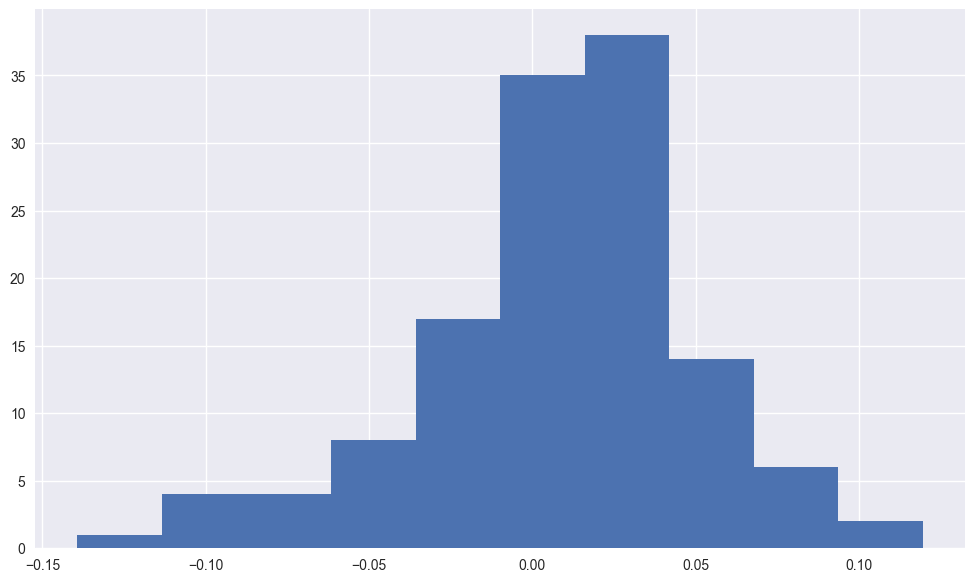

In [342]:
q1backtest.fulldata['total_return'].hist()

<Axes: xlabel='date'>

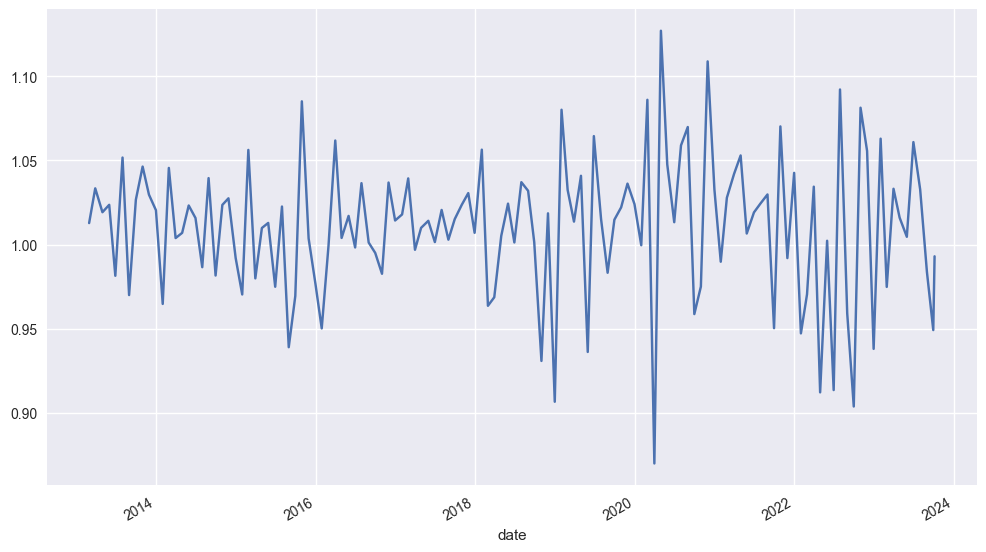

In [345]:
q1backtest.fulldata['total_return_exp'].plot()

In [350]:
q1backtest.mean_returns = q1backtest.fulldata['total_return_exp'].mean()
q1backtest.std_returns = q1backtest.fulldata['total_return_exp'].std(ddof=1)
q1backtest.est_sharpe = q1backtest.mean_returns/q1backtest.std_returns

In [351]:
q1backtest.est_sharpe

23.874603997593066

In [344]:
mod_list = [q1_model, q1backtest]
bigholder = []

for x in mod_list:
    smallholder = {}
    if x.split == True:
        smallholder['model'] = q1_model.name
        smallholder['precision_train'] = q1_model.bigscoretrain[0]
        smallholder['recall_train'] = q1_model.bigscoretrain[1]
        smallholder['f1_train'] = q1_model.bigscoretrain[2]
        smallholder['auc_train'] = q1_model.auc_train
        smallholder['precision_test'] = q1_model.bigscoretest[0]
        smallholder['recall_test'] = q1_model.bigscoretest[1]
        smallholder['f1_test'] = q1_model.bigscoretest[2]
        smallholder['auc_test'] = q1_model.auc_test
        bigholder.append(smallholder)
    else:
        smallholder['model'] = q1backtest.name
        smallholder['precision'] = q1backtest.bigscore[0]
        smallholder['recall'] = q1backtest.bigscore[1]
        smallholder['f1'] = q1backtest.bigscore[2]
        smallholder['auc'] = q1backtest.auc
        bigholder.append(smallholder)
scores_df = pd.DataFrame(bigholder)
scores_df


,model,precision_train,recall_train,f1_train,auc_train,precision_test,recall_test,f1_test,auc_test,precision,recall,f1,auc
0,q1,1.0,1.0,1.0,1.0,0.555556,0.625,0.588235,0.555556,NaN,NaN,NaN,NaN
1,q1_backtest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.674419,1.0,0.805556,0.674419


## Question 2

Use the first RF model from Part 4 of the Module 5: Coding Assignment. Find the annualized average return and Sharpe ratio of this strategy over the train and test sets as defined in that coding assignment (you can assume the risk-free rate to be zero when computing Sharpe ratio). Why can’t we backtest a trading strategy using the SPX index directly? (16 points) 

Based on our analysis it looks like the Estimated Sharpe Ratio (ESR) = 0.5871928663595524.

Interestingly when we do the annualized estimate we get 2.034095756753493.

Backtesting a trading strategy on SPX is weird since we can't buy/sell SPX directly. If we used SPY based on it we could model a strategy for trading against something that follows the SPX.

In [394]:
"""xdat = pd.read_csv('X_processed_final.csv')
ydat = pd.read_csv('y_final.csv')
combined = pd.concat([xdat, ydat], axis=1)
seed1_combined = combined[['yyyymm', 'lty_FD', 'd/e', 'tms', 'ret']]
seed2_combined = combined[['yyyymm', 'e/p', 'd/e', 'infl', 'ret']]

seed1_model = pickle.load(open('./top5featRF-seed1.sav', 'rb'))
seed2_model = pickle.load(open('./top5featRF-seed2.sav', 'rb'))"""

In [434]:
seed1_data = pd.read_csv('./seed1export.csv')
seed1_data.set_index('yyyymm', inplace=True)
seed2_data = pd.read_csv('./seed2export.csv')
seed2_data.set_index('yyyymm', inplace=True)
full = pd.read_csv('./full_with_returns.csv')
full.rename(columns={'ret':'log_return'}, inplace=True)
full.set_index('yyyymm', inplace=True)

In [435]:
seed1_analysis = seed1_data.copy().merge(full[['log_return']], left_index=True, right_index=True, how='left')
seed1_analysis['correct'] = np.where(seed1_analysis['predicted'] == seed1_analysis['ret'], 1, 0)
#seed1_analysis.sort_index(inplace=True)
seed1_analysis['short_return'] = np.where(seed1_analysis['predicted'] == -1, -1*seed1_analysis['log_return'], 0)
seed1_analysis['long_return'] = np.where(seed1_analysis['predicted'] == 1, seed1_analysis['log_return'], 0)
seed1_analysis['total_return'] = seed1_analysis['short_return'] + seed1_analysis['long_return']
seed1_analysis['total_return_exp'] = np.exp(seed1_analysis['total_return'])
seed1_analysis['cumulative_return'] = seed1_analysis['total_return'].cumsum()
seed1_analysis['cumulative_return_exp'] = seed1_analysis['total_return_exp'].cumsum()

In [437]:
seed1_analysis.head()

,lty_FD,d/e,tms,ret,predicted,ntis,infl,ltr,corpr,svar,...,b/m_FD,tbl_FD,log_return,correct,short_return,long_return,total_return,total_return_exp,cumulative_return,cumulative_return_exp
yyyymm,,,,,,,,,,,,,,,,,,,,,
1945-12-01,-1.507835,-0.374693,0.0161,1.0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.067062,1,0.000000,0.067062,0.067062,1.069362,0.067062,1.069362
1946-01-01,-1.486065,-0.343589,0.0161,-1.0,-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.072314,1,0.072314,0.000000,0.072314,1.074993,0.139376,2.144355
1946-02-01,-1.481915,-0.312134,0.0160,1.0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.044940,1,0.000000,0.044940,0.044940,1.045965,0.184316,3.190320
1946-03-01,-1.474585,-0.280302,0.0160,1.0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.036604,1,0.000000,0.036604,0.036604,1.037282,0.220920,4.227602
1946-04-01,-1.425691,-0.257829,0.0169,1.0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.021824,1,0.000000,0.021824,0.021824,1.022064,0.242745,5.249666


In [444]:
seed1_analysis_v2 = seed1_analysis.iloc[1:,]

In [427]:
seed1_analysis_avg_ann_return = seed1_analysis_v2['total_return'].mean()*12
seed1_analysis_avg_ann_return

In [447]:
seed1_analysis_v2.index = pd.to_datetime(seed1_analysis_v2.index, format='mixed')

In [481]:
#check to make sure we have 12 months of data per year
seed1_analysis_v2.groupby(pd.Grouper(freq='YE'))['total_return'].size().reset_index()

,yyyymm,total_return
0,1946-12-31,12
1,1947-12-31,12
2,1948-12-31,12
3,1949-12-31,12
4,1950-12-31,12
...,...,...
68,2014-12-31,12
69,2015-12-31,12
70,2016-12-31,12
71,2017-12-31,12


In [482]:
ann_estimated_sr = sr_funcs.ann_estimated_sharpe_ratio(seed1_analysis_v2['total_return'], 12)
ann_estimated_sr

2.034095756753493

In [483]:
esr = sr_funcs.estimated_sharpe_ratio(seed1_analysis_v2['total_return'])
esr


0.5871928663595524

In [484]:
sr_stdv = sr_funcs.estimated_sharpe_ratio_stdev(seed1_analysis_v2['total_return'])
sr_stdv

0.045310615472214086

## Question 3

Based on the assigned reading from Bailey and López de Prado (2011)Links to an external site., what is the approximate probability (to within 1 significant digit) that the “true” Sharpe ratio is greater than 0 for your backtest over the test set? (You can use the zip file on Probabilistic Sharpe Ratio that you downloaded in Part 1 of this assignment for this calculation) (24 points)

Our function returns a PSR of 1 meaning we have a 100% probability of our SR being greater than 0. 

If we don't round it it's 0.989695457059597. Rounding to 2 figs we get 99% chance.




In [485]:
sr_funcs.probabilistic_sharpe_ratio(q1backtest.fulldata.iloc[1:,]['total_return'])

0.989695457059597

In [486]:
round(sr_funcs.probabilistic_sharpe_ratio(q1backtest.fulldata.iloc[1:,]['total_return']),1)

1.0

## Question 4

Repeat Parts #1 and #2 of this assignment by using the RF model created in Part 6 of the coding assignment in Module 5. Does the Sharpe ratio over the test set change? (16 points)


ESR = 0.6139636457203063

AESR = 2.1268324567755768

It looks like seed 2 is a little bit higher for both the ESR and AESR.



In [487]:
seed2_analysis = seed2_data.copy().merge(full[['log_return']], left_index=True, right_index=True, how='left')
seed2_analysis['correct'] = np.where(seed2_analysis['predicted'] == seed2_analysis['ret'], 1, 0)
#seed2_analysis.sort_index(inplace=True)
seed2_analysis['short_return'] = np.where(seed2_analysis['predicted'] == -1, -1*seed2_analysis['log_return'], 0)
seed2_analysis['long_return'] = np.where(seed2_analysis['predicted'] == 1, seed2_analysis['log_return'], 0)
seed2_analysis['total_return'] = seed2_analysis['short_return'] + seed2_analysis['long_return']
seed2_analysis['total_return_exp'] = np.exp(seed2_analysis['total_return'])
seed2_analysis['cumulative_return'] = seed2_analysis['total_return'].cumsum()
seed2_analysis['cumulative_return_exp'] = seed2_analysis['total_return_exp'].cumsum()

In [488]:
seed2_analysis_v2 = seed2_analysis.iloc[1:,]
seed2_analysis_avg_ann_return = seed2_analysis_v2['total_return'].mean()*12
seed2_analysis_avg_ann_return
seed2_analysis_v2.index = pd.to_datetime(seed2_analysis_v2.index, format='mixed')
seed2_analysis_v2.groupby(pd.Grouper(freq='YE'))['total_return'].size().reset_index()

,yyyymm,total_return
0,1946-12-31,12
1,1947-12-31,12
2,1948-12-31,12
3,1949-12-31,12
4,1950-12-31,12
...,...,...
68,2014-12-31,12
69,2015-12-31,12
70,2016-12-31,12
71,2017-12-31,12


In [489]:
ann_estimated_sr_seed2 = sr_funcs.ann_estimated_sharpe_ratio(seed2_analysis_v2['total_return'], 12)
ann_estimated_sr_seed2

2.1268324567755768

In [490]:
esr_seed2 = sr_funcs.estimated_sharpe_ratio(seed2_analysis_v2['total_return'])
esr_seed2


0.6139636457203063

In [492]:
sr_funcs.probabilistic_sharpe_ratio(seed1_analysis_v2['total_return'])

1.0

In [491]:
sr_funcs.probabilistic_sharpe_ratio(seed2_analysis_v2['total_return'])

1.0

## Question 5

Instead of using the theoretical results of the paper cited in Part 3 of this assignment, identify and explain an empirical way to find out the probability that your “true” Sharpe ratio will be positive. (16 points)

I think one way of doing this would be monte carlo style. We run 100's of simulations while only changing the random seed. This should give us that variance we saw between the seed1 and seed2 results. Once we have hundreds of these results we should be able to determine based on the distribution what the 'true' sharpe ratio will be. We should actually be able to just take the average and trust that average.